In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('data/clean_df.csv')

In [3]:
df.head()

,date,incident_id,governorate,district,area,target,main_category,sub_category,min_air_raids,max_air_raids,civilian_casualties,fatalities,woman_fatalities,child_fatalities,injured,woman_injured,child_injured,confirmed_time,time_of_day
0,2015-03-26,1,Sanaa,bani al-harith,Al-Rahabah,Al-Daylami Airbase,military_security_target,military site,1,2.0,0,0,0,0,0,0,0.0,2,morning
1,2015-03-26,2,Sanaa,bani al-harith,Airport,Sana'a International Airport,infrastructure,transport,1,2.0,0,0,0,0,0,0,0.0,2,morning
2,2015-03-26,3,Sanaa,bani al-harith,Al-Sonblah Neighbourhood,Residential Area,civilian,residential area,1,2.0,29,21,3,14,8,0,7.0,2,morning
3,2015-03-26,4,Sanaa,al-sab'ein,Al-Nahdain,Presidential Palace,military_security_target,military site,1,2.0,0,0,0,0,0,0,0.0,3,morning
4,2015-03-26,5,Sanaa,al-thawrah,Al-Nahdhah,Former 1st Armoured Division,military_security_target,military site,1,2.0,0,0,0,0,0,0,0.0,3,morning


In [4]:
df['date'] = pd.to_datetime(df['date'])
df.index = df['date'] 
df = df.resample('M').sum()

In [5]:
df

,incident_id,min_air_raids,max_air_raids,civilian_casualties,fatalities,woman_fatalities,child_fatalities,injured,woman_injured,child_injured
date,,,,,,,,,,
2015-01-31,529627,225,809.0,270,130,19,11,140,15,11.0
2015-02-28,442638,179,450.0,121,56,7,8,65,5,0.0
2015-03-31,499605,377,854.0,479,216,12,38,263,39,49.0
2015-04-30,660959,546,1405.0,1647,424,13,27,1223,4,15.0
2015-05-31,927581,522,1295.0,616,357,24,43,259,13,22.0
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,3892117,180,696.0,2,2,2,0,0,0,0.0
2020-09-30,4589569,211,682.0,8,4,0,1,4,0,0.0
2020-10-31,3789224,174,592.0,8,3,0,0,5,1,2.0


# Seasonality

In [6]:
decomp = seasonal_decompose(df['civilian_casualties'])

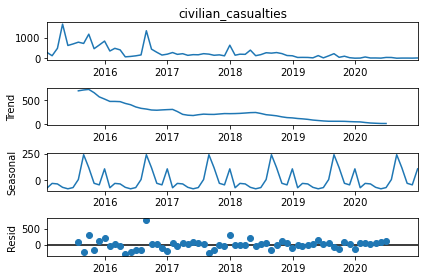

In [7]:
decomp.plot();

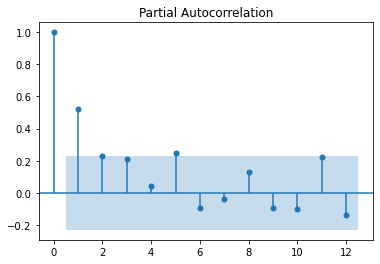

In [21]:
plot_pacf(df['civilian_casualties'], lags=12, alpha=.05);

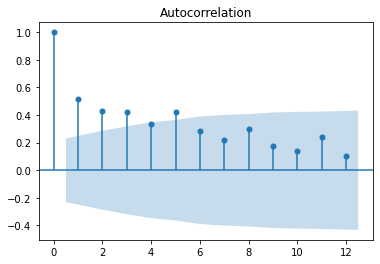

In [23]:
plot_acf(df['civilian_casualties'], lags=12, alpha=.05);

# Checking Stationarity

In [10]:
df['first_diff'] = df['civilian_casualties'].diff()

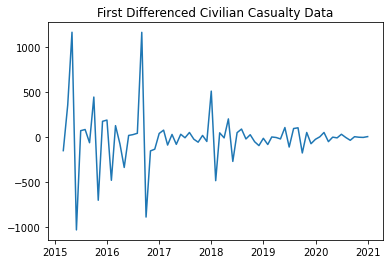

In [11]:
plt.plot(df['first_diff'])
plt.title('First Differenced Civilian Casualty Data');

# Arima Modeling

In [12]:
y_train, y_test = train_test_split(df['civilian_casualties'].diff(), random_state=6, shuffle=False, test_size=.1)

In [13]:
model = ARIMA(endog=y_train, order=(0, 1, 2)).fit()
predictions = model.predict(start=y_test.index[0], end=y_test.index[-1])
predictions

/Users/garrettnelson/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2020-05-31   -30.954185
2020-06-30   -10.365298
2020-07-31   -10.365298
2020-08-31   -10.365298
2020-09-30   -10.365298
2020-10-31   -10.365298
2020-11-30   -10.365298
2020-12-31   -10.365298
Freq: M, Name: predicted_mean, dtype: float64

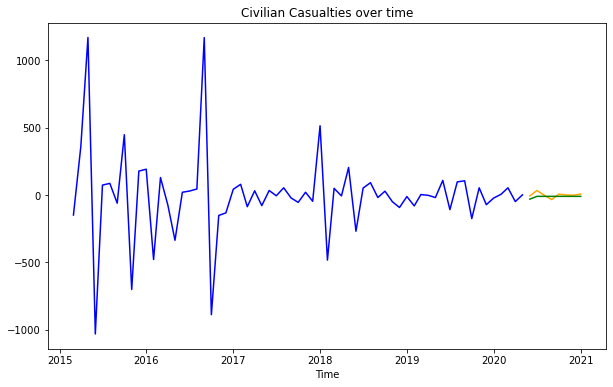

In [14]:
# Plotting the Model
plt.figure(figsize=(10,6))
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue') #training data
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange') # testing data
plt.plot(y_test.index, predictions, color = 'green') # predictions based on testing data
plt.title('Civilian Casualties over time')
plt.xlabel('Time');

In [15]:
adfuller(df['civilian_casualties'])

(-4.6274360247972695,
 0.00011493619402070795,
 0,
 71,
 {'1%': -3.526004646825607,
  '5%': -2.9032002348069774,
  '10%': -2.5889948363419957},
 789.2428319428723)

In [16]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [17]:
interpret_dftest(adfuller(df['civilian_casualties']))

Test Statistic   -4.627436
p-value           0.000115
dtype: float64